In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
torch.cuda.empty_cache()

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from IPython.display import Image


In [5]:
import torch
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
import json
from functools import partial
from torch import einsum, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import pack, rearrange, reduce, repeat, unpack


In [ ]:
!python evaluate_generator.py

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda
Sync is turned on False
loaded model with  0.03015906736254692 tensor([110000.], device='cuda:0') steps
/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Total number of motions humanml: 8802 and texts 8802
/coc/scratch/sanisetty3/music_motion/ATCMG/core/datasets/tmr_dataset.py:2

## Helpers

In [6]:
from configs.config import cfg, get_cfg_defaults
def load_vqvae(gen_cfg):

    body_cfg = get_cfg_defaults()
    body_cfg.merge_from_file(gen_cfg.vqvae.body_config)
    body_model = (
        instantiate_from_config(body_cfg.vqvae).to(device).eval()
    )
    body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

    if gen_cfg.vqvae.left_hand_config is  None and gen_cfg.vqvae.right_hand_config is None:
        return body_model, body_cfg
    
    if gen_cfg.vqvae.left_hand_config is not None:
        left_cfg = get_cfg_defaults()
        left_cfg.merge_from_file(gen_cfg.vqvae.left_hand_config)
        left_hand_model = instantiate_from_config(left_cfg.vqvae).to(device).eval()
        left_hand_model.load(
            os.path.join(left_cfg.output_dir, "vqvae_motion.pt")
        )
    else:
        left_hand_model = None
        
    if gen_cfg.vqvae.right_hand_config is not None:
        right_cfg = get_cfg_defaults()
        right_cfg.merge_from_file(gen_cfg.vqvae.right_hand_config)
        right_hand_model = instantiate_from_config(right_cfg.vqvae).to(device).eval()
        right_hand_model.load(
            os.path.join(right_cfg.output_dir, "vqvae_motion.pt")
        )
    else:
        right_hand_model = None

    return body_model, left_hand_model , right_hand_model , body_cfg , left_cfg , right_cfg

def bkn_to_motion( codes, dset , remove_translation = True):
    # codes b k n

    k = codes.shape[1]
    mrep = dset.motion_rep

    if k == 1:
        if mrep == MotionRep("body"):

            body_inds = codes[:, 0]
            body_motion = body_model.decode(body_inds[0:1]).detach().cpu()

            if remove_translation:
                z = torch.zeros(
                    body_motion.shape[:-1] + (2,),
                    dtype=body_motion.dtype,
                    device=body_motion.device,
                )
                body_motion = torch.cat(
                    [body_motion[..., 0:1], z, body_motion[..., 1:]], -1
                )

            body_M = dset.toMotion(
                body_motion[0],
                motion_rep=MotionRep("body"),
                hml_rep=body_cfg.dataset.hml_rep,
            )

            return body_M

        elif mrep == MotionRep("left_hand"):

            left_inds = codes[:, 0]
            left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
            left_M = dset.toMotion(
                left_motion[0],
                motion_rep=MotionRep(left_cfg.dataset.motion_rep),
                hml_rep=left_cfg.dataset.hml_rep,
            )
            return left_M

        elif mrep == MotionRep("right_hand"):
            right_inds = codes[:, 0]
            right_motion = (
                right_hand_model.decode(right_inds[0:1]).detach().cpu()
            )
            right_M = dset.toMotion(
                right_motion[0],
                motion_rep=MotionRep(right_cfg.dataset.motion_rep),
                hml_rep=right_cfg.dataset.hml_rep,
            )
            return right_M

    if k == 2:
        left_inds = codes[:, 0]
        right_inds = codes[:, 1]

        left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
        right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()

        left_M = dset.toMotion(
            left_motion[0],
            motion_rep=MotionRep(left_cfg.dataset.motion_rep),
            hml_rep=left_cfg.dataset.hml_rep,
        )
        right_M = dset.toMotion(
            right_motion[0],
            motion_rep=MotionRep(right_cfg.dataset.motion_rep),
            hml_rep=right_cfg.dataset.hml_rep,
        )
        hand_M = left_M + right_M
        hand_M.motion_rep = MotionRep.HAND
        hand_M.hml_rep = "".join(
            [i for i in left_M.hml_rep if i in right_M.hml_rep]
        )
        return hand_M

    if k == 3:
        left_inds = codes[:, 1]
        right_inds = codes[:, 2]
        body_inds = codes[:, 0]
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()

        
        if remove_translation:
            z = torch.zeros(
                body_motion.shape[:-1] + (2,),
                dtype=body_motion.dtype,
                device=body_motion.device,
            )
            body_motion = torch.cat([body_motion[..., 0:1], z, body_motion[..., 1:]], -1)

        left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
        right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()

        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep("body"),
            hml_rep = body_cfg.dataset.hml_rep)

        left_M = dset.toMotion(
            left_motion[0],
            motion_rep=MotionRep("left_hand"),
            hml_rep=left_cfg.dataset.hml_rep)
        right_M = dset.toMotion(
            right_motion[0],
            motion_rep=MotionRep("right_hand"),
            hml_rep=right_cfg.dataset.hml_rep)
        full_M = dset.to_full_joint_representation(body_M, left_M, right_M)
        return full_M



## TMR

In [7]:
from core.models.utils import instantiate_from_config, get_obj_from_str
from core.datasets.tmr_dataset import TMRDataset, load_dataset, simple_collate
from core import MotionRep, TextRep, AudioRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from configs.config_tmr import get_cfg_defaults as get_cfg_defaults_tmr
from core.models.TMR.tmr import TMR
from core.models.TMR.tmr import get_score_matrix


/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
tmr_cfg = get_cfg_defaults_tmr()
tmr_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/tmr/tmr.yaml")
# tmr_cfg.freeze()
dataset_args = tmr_cfg.dataset
tmr_parms = tmr_cfg.tmr


In [9]:


_ = tmr_parms.pop("target")
motion_encoder = instantiate_from_config(tmr_cfg.motion_encoder).to(device)
text_encoder = instantiate_from_config(tmr_cfg.text_encoder).to(device)
motion_decoder = instantiate_from_config(tmr_cfg.motion_decoder).to(device)
tmr = TMR(motion_encoder , text_encoder , motion_decoder , lr = tmr_cfg.train.learning_rate, **tmr_parms).to(device).eval()
pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/tmr/tmr.pt")
tmr.load_state_dict(pkg["model"])

<All keys matched successfully>

In [11]:
def get_latents(inputs , conditions):
    text_conds = conditions["text"]
    text_x_dict = {"x": text_conds[0], "mask": text_conds[1].to(torch.bool)}
    motion_x_dict = {"x": inputs[0], "mask": inputs[1].to(torch.bool)}
    motion_mask = motion_x_dict["mask"]
    text_mask = text_x_dict["mask"]
    t_motions, t_latents, t_dists = tmr(
            text_x_dict, mask=motion_mask, return_all=True, sample_mean = True
        )

    # motion -> motion
    m_motions, m_latents, m_dists = tmr(
        motion_x_dict, mask=motion_mask, return_all=True, sample_mean = True
    )
    return t_latents , m_latents

In [ ]:
# dataset_names = ["humanml"] ,

In [9]:
train_ds, sampler_train, weights_train  = load_dataset( dataset_names = ["choreomaster"] ,dataset_args=dataset_args, split = "test")


Total number of motions choreomaster: 2 and texts 2


In [10]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            fps=30,
            # only_motion = True
        )
condition_provider.audio_dim = 128

In [11]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

In [28]:
for inputs, conditions in (train_loader):
    break

In [13]:
motion  = train_ds.datasets[0][0]["motion"]

In [15]:
motion_inv = train_ds.datasets[0].inv_transform(motion)

In [16]:
motion_xyz = train_ds.datasets[0].to_xyz(motion_inv)

In [17]:
motion_xyz.shape

torch.Size([180, 22, 3])

In [27]:
motion = inputs["motion"][0]
motion_mask = inputs["motion"][1].to(torch.bool)
text = conditions["text"][0]
text_mask = conditions["text"][1].to(torch.bool)

In [28]:
motion_mask.shape

torch.Size([1, 252])

In [18]:
losses = tmr.compute_loss(inputs["motion"] , conditions)
losses

{'recons': tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>),
 'kl': tensor(74.1251, device='cuda:0', grad_fn=<AddBackward0>),
 'latent': tensor(1.0820, device='cuda:0', grad_fn=<SmoothL1LossBackward0>),
 'contrastive': tensor(0., device='cuda:0', grad_fn=<DivBackward0>),
 'loss': tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)}

In [18]:
t_latents , m_latents = get_latents(inputs["motion"],conditions)
score = get_score_matrix(t_latents, m_latents).cpu()
score

tensor([[0.8913, 0.5509, 0.5515, 0.7459],
        [0.5962, 0.8877, 0.4547, 0.6056],
        [0.5355, 0.4400, 0.8875, 0.6353],
        [0.5808, 0.6178, 0.5276, 0.9520]], grad_fn=<ToCopyBackward0>)

## TMR EVAL

### Retreival

In [53]:
import torch
import numpy as np
from core.models.TMR.tmr import get_score_matrix, get_sim_matrix
from core.models.TMR.metrics import all_contrastive_metrics

In [46]:
def get_latents(inputs , conditions):
    text_conds = conditions["text"]
    text_x_dict = {"x": text_conds[0], "mask": text_conds[1].to(torch.bool)}
    motion_x_dict = {"x": inputs[0], "mask": inputs[1].to(torch.bool)}
    motion_mask = motion_x_dict["mask"]
    text_mask = text_x_dict["mask"]
    t_latents = tmr.encode(
            text_x_dict, sample_mean = True
        )

    # motion -> motion
    m_latents = tmr.encode(
        motion_x_dict,  sample_mean = True
    )
    return t_latents , m_latents

In [43]:
def compute_sim_matrix(model, sent_embedder ,train_loader, batch_size=256):
    
    # nsplit = int(np.ceil(len(dataset) / batch_size))
    with torch.inference_mode():
        # all_data = [dataset.load_keyid(keyid) for keyid in keyids]
        # all_data_splitted = np.array_split(all_data, nsplit)

        # by batch (can be too costly on cuda device otherwise)
        latent_texts = []
        latent_motions = []
        sent_embs = []
        for inputs , conditions in tqdm(train_loader, leave=False):
            # batch = collate_text_motion(data, device=device)
            tkn = sent_embedder.tokenize(list(inputs["texts"]))
            sent_emb, sent_msk = sent_embedder.get_text_embedding(tkn)
            latent_text ,latent_motion =  get_latents(inputs["motion"] , conditions)

            latent_texts.append(latent_text)
            latent_motions.append(latent_motion)
            sent_embs.append(sent_emb)

        latent_texts = torch.cat(latent_texts)
        latent_motions = torch.cat(latent_motions)
        sent_embs = torch.cat(sent_embs)
        sim_matrix = get_sim_matrix(latent_texts, latent_motions)
    returned = {
        "sim_matrix": sim_matrix.cpu().numpy(),
        "sent_emb": sent_embs.cpu().numpy(),
    }
    return returned

In [58]:
mpnet = SentenceConditioner(name = "sentence-transformers/all-mpnet-base-v2").to(device)
sbert = SentenceConditioner(name = "sentence-transformers/all-MiniLM-L6-v2").to(device)


In [37]:
tmr_cfg = get_cfg_defaults_tmr()
tmr_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/tmr/tmr.yaml")
# tmr_cfg.freeze()
dataset_args = tmr_cfg.dataset
tmr_parms = tmr_cfg.tmr


_ = tmr_parms.pop("target")
motion_encoder = instantiate_from_config(tmr_cfg.motion_encoder).to(device)
text_encoder = instantiate_from_config(tmr_cfg.text_encoder).to(device)
motion_decoder = instantiate_from_config(tmr_cfg.motion_decoder).to(device)
tmr = TMR(motion_encoder , text_encoder , motion_decoder , lr = tmr_cfg.train.learning_rate, **tmr_parms).to(device).eval()
pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/tmr/tmr.pt")
tmr.load_state_dict(pkg["model"])

<All keys matched successfully>

In [79]:
train_ds, sampler_train, weights_train  = load_dataset(dataset_args=dataset_args, split = "test")
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            fps=30,
            # only_motion = True
        )
condition_provider.audio_dim = 128

Total number of motions animation: 2 and texts 2
Total number of motions humanml: 8802 and texts 8802
Total number of motions perform: 16 and texts 16
Total number of motions GRAB: 67 and texts 67
Total number of motions idea400: 577 and texts 577
Total number of motions humman: 20 and texts 20
Total number of motions beat: 162 and texts 162
Total number of motions game_motion: 131 and texts 131
Total number of motions music: 148 and texts 148
Total number of motions aist: 61 and texts 61
Total number of motions fitness: 572 and texts 572
Total number of motions moyo: 9 and texts 9
Total number of motions choreomaster: 2 and texts 2
Total number of motions dance: 7 and texts 7
Total number of motions kungfu: 42 and texts 42
Total number of motions EgoBody: 49 and texts 49
Total number of motions HAA500: 17 and texts 17


In [80]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        256,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

In [81]:
res = compute_sim_matrix(
                    tmr, t5, train_loader, batch_size=256
                )

In [82]:
sim_matrix = res["sim_matrix"]

In [75]:
metrics = all_contrastive_metrics(sim_matrix, None, threshold=None)

In [76]:
metrics

{'t2m/R01': 0.24,
 'm2t/R01': 3.48,
 't2m/R02': 5.74,
 'm2t/R02': 5.19,
 't2m/R03': 5.93,
 'm2t/R03': 7.65,
 't2m/R05': 10.85,
 'm2t/R05': 11.26,
 't2m/R10': 15.15,
 'm2t/R10': 18.51,
 't2m/MedR': 65.0,
 'm2t/MedR': 60.0,
 't2m/len': 8704.0,
 'm2t/len': 8704.0}

In [83]:
metrics2 = all_contrastive_metrics(sim_matrix, res["sent_emb"], threshold=0.9)

In [84]:
metrics2

{'t2m/R01': 10.78,
 'm2t/R01': 30.15,
 't2m/R02': 49.77,
 'm2t/R02': 34.36,
 't2m/R03': 51.25,
 'm2t/R03': 43.38,
 't2m/R05': 59.84,
 'm2t/R05': 50.81,
 't2m/R10': 67.7,
 'm2t/R10': 60.18,
 't2m/MedR': 3.0,
 'm2t/MedR': 5.5,
 't2m/len': 10496.0,
 'm2t/len': 10496.0}

### Sent emb

In [12]:
from core.datasets.text_encoders import T5Conditioner,SentenceConditioner
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
sents = [
"A human walking backwards.",
    "A person is walking backwards.",
    "Someone walks in a circle counterclockwis",
    "A person walks a full counter-clockwise circle.",
    "A human performs a tight 90◦ curve to the right.",
"A person walks a quarter circle clockwise with 4 steps",
   "human goes backwards starting with left",
    "A person walks backwards.",
    "a person walks in a circle to the left side.",
    "trump"
    
]

In [13]:
t5 = T5Conditioner("t5-large").to(device)
sbert = SentenceConditioner(name = "sentence-transformers/all-MiniLM-L6-v2").to(device)
mpnet = SentenceConditioner(name = "sentence-transformers/all-mpnet-base-v2").to(device)

In [14]:
def cosine_similarity_matrix(embeddings):
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
    return similarity_matrix



In [18]:
sent_embed1, _ = t5.get_text_embedding(t5.tokenize(sents))
sent_embed2, _ = sbert.get_text_embedding(sbert.tokenize(sents))
sent_embed3, _ = mpnet.get_text_embedding(mpnet.tokenize(sents))

In [31]:
print(sent_embed1.shape , sent_embed2.shape , sent_embed3.shape)

torch.Size([10, 1024]) torch.Size([10, 384]) torch.Size([10, 768])


In [21]:
similarity_matrix1 = cosine_similarity_matrix(sent_embed1.cpu())
similarity_matrix2 = cosine_similarity_matrix(sent_embed2.cpu())
similarity_matrix3 = cosine_similarity_matrix(sent_embed3.cpu())

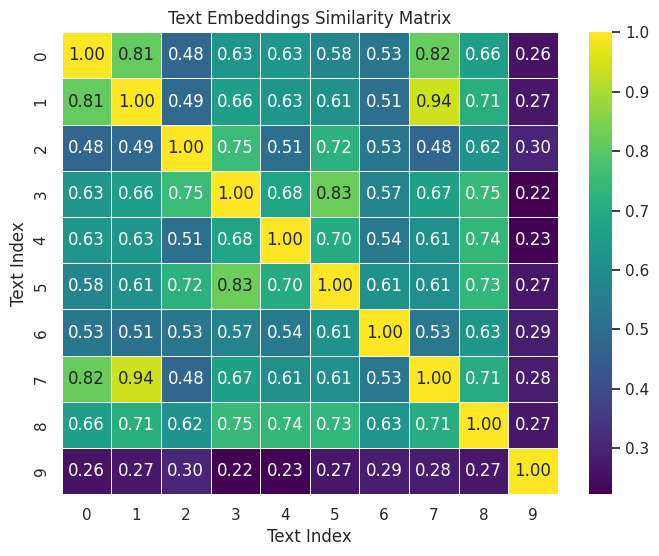

In [27]:
sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix1, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Text Embeddings Similarity Matrix')
plt.xlabel('Text Index')
plt.ylabel('Text Index')
plt.show()

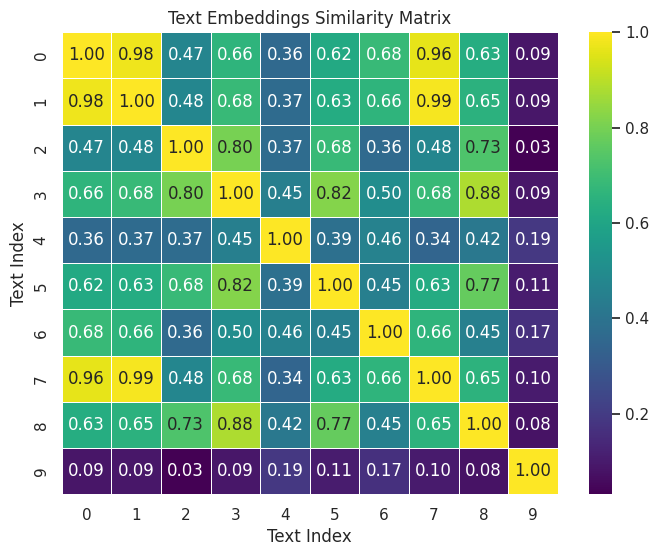

In [28]:
sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix2, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Text Embeddings Similarity Matrix')
plt.xlabel('Text Index')
plt.ylabel('Text Index')
plt.show()

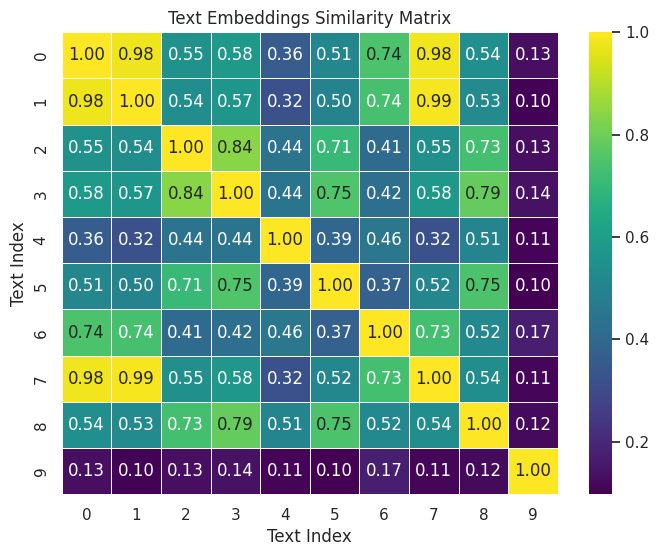

In [29]:
sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix3, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Text Embeddings Similarity Matrix')
plt.xlabel('Text Index')
plt.ylabel('Text Index')
plt.show()

### Eval

In [19]:
from core.models.TMR.tmr import get_score_matrix
import random

In [20]:
# condition_provider = ConditionProvider(
#             text_conditioner_name = dataset_args.text_conditioner_name,
#             motion_rep=MotionRep(dataset_args.motion_rep),
#             audio_rep=AudioRep(dataset_args.audio_rep),
#             text_rep=TextRep(dataset_args.text_rep),
#             motion_padding=dataset_args.motion_padding,
#             motion_max_length_s=dataset_args.motion_max_length_s,
#             fps=30,
#             # only_motion = True
#         )

In [21]:
# from core.datasets.base_dataset import BaseMotionDataset
# base_dset = BaseMotionDataset(motion_rep=MotionRep.FULL , hml_rep= "gprvc")

In [22]:
def getScore(text:str , motion_path:str, return_embeds = False):
    motion = np.load(motion_path)

    text_embed, text_mask = condition_provider._get_text_features(
        raw_text=text,
    )
    processed_motion = base_dset.get_processed_motion(
            motion, motion_rep=MotionRep(dataset_args.motion_rep), hml_rep=dataset_args.hml_rep
        )
    mot_body = torch.Tensor(processed_motion()).to(device)[None]
    print(mot_body.shape)
    motion_x_dict = {"x": mot_body, "mask": torch.ones_like(mot_body)[...,0].to(torch.bool)}
    text_x_dict = {"x": text_embed, "mask": text_mask.to(torch.bool)}
    with torch.no_grad():
        lat_m = tmr.encode(motion_x_dict, sample_mean=True)[0]
        lat_t = tmr.encode(text_x_dict, sample_mean=True)[0]
        score = get_score_matrix(lat_t, lat_m).cpu()

    if return_embeds:
        return score ,lat_m ,lat_t
    return score

In [121]:
text="a man sets to do a backflips then fails back flip and falls to the ground"
mot="/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/humanml/001034.npy"
text2 = "a person standing loses balance falling to the right and recovers standing"
mot2="/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/humanml/000012.npy"

In [122]:
motion = np.load(mot)
motion2 = np.load(mot2)

In [123]:
getScore(text , motion)

torch.Size([1, 120, 137])


tensor(0.7139)

In [124]:
getScore(text2 , motion2)

torch.Size([1, 120, 137])


tensor(0.9692)

## Muse Gen

In [19]:
from core.models.generation.muse2 import generate_animation
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
# from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
# from core import MotionRep, AudioRep, TextRep
# from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse2 import MotionMuse as MotionMuse2
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults
import math

In [20]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_body_hands/motion_muse_body_hands.yaml")
gen_cfg.freeze()
tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern
# dataset_args = gen_cfg.dataset

target = tranformer_config.pop("target")
motion_gen = MotionMuse2(tranformer_config , fuse_config , pattern_config).to(device).eval()
pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_body_hands/motion_muse.pt", map_location="cuda")
motion_gen.load_state_dict(pkg["model"])

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


<All keys matched successfully>

In [21]:
body_model, left_hand_model , right_hand_model , body_cfg , left_cfg , right_cfg = load_vqvae(gen_cfg)

Sync is turned on False
loaded model with  0.03015906736254692 tensor([110000.], device='cuda:0') steps


In [22]:
from core.datasets.base_dataset import BaseMotionDataset
base_dset = BaseMotionDataset(motion_rep=MotionRep.BODY , hml_rep= "gpvc")

In [112]:
inputs["lens"].min()

tensor(183.)

In [100]:
text_ = inputs["texts"][-1]
duration_s = inputs["lens"][-1]//30

In [113]:
duration_s = int(inputs["lens"].min()//30)

In [115]:
all_ids_body = generate_animation(motion_gen , condition_provider ,overlap = 15, duration_s = duration_s ,  text = text_ , use_token_critic = True, timesteps = 24 )
gen_motion = bkn_to_motion(all_ids_body[:,:1], base_dset)

100%|███████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 37.02it/s]


In [109]:
# gen_motion = bkn_to_motion(all_ids_body[:,:1], base_dset)
# base_dset.render_hml(
#                     gen_motion,
#                     f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel_full.gif",
#                     zero_trans = True,
#                     zero_orient = True,
    
#                 )
# Image(open(f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel_full.gif",'rb').read())

# Evaluate Text

In [10]:
from core.models.utils import instantiate_from_config, get_obj_from_str


In [11]:

from configs.config_tmr import get_cfg_defaults as get_cfg_defaults_tmr
from core.models.TMR.tmr import TMR
from core.models.TMR.tmr import get_score_matrix


In [12]:
tmr_cfg = get_cfg_defaults_tmr()
tmr_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/tmr/tmr.yaml")
# tmr_cfg.freeze()
dataset_args_tmr = tmr_cfg.dataset
tmr_parms = tmr_cfg.tmr

In [11]:


_ = tmr_parms.pop("target")
motion_encoder = instantiate_from_config(tmr_cfg.motion_encoder).to(device)
text_encoder = instantiate_from_config(tmr_cfg.text_encoder).to(device)
motion_decoder = instantiate_from_config(tmr_cfg.motion_decoder).to(device)
tmr = TMR(motion_encoder , text_encoder , motion_decoder , lr = tmr_cfg.train.learning_rate, **tmr_parms).to(device).eval()
pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/tmr/tmr.pt")
tmr.load_state_dict(pkg["model"])

<All keys matched successfully>

In [13]:
from core.datasets.tmr_dataset import load_dataset as load_dataset_tmr
from core.datasets.tmr_dataset import simple_collate as simple_collate_tmr

from core import MotionRep, TextRep, AudioRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser

In [15]:
train_ds, sampler_train, weights_train  = load_dataset_tmr( dataset_names = ["aist"] ,dataset_args=dataset_args, split = "test")


Total number of motions aist: 61 and texts 61


In [16]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            fps=30,
            # only_motion = True
        )
condition_provider.audio_dim = 128


In [17]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        32,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

### Evaluate VQVAE

In [14]:
from core.eval.eval_text.eval_text import evaluation_transformer, evaluation_vqvae
from functools import partial
from configs.config import get_cfg_defaults as vqvae_get_cfg_defaults


In [15]:
body_cfg_1024 = vqvae_get_cfg_defaults()
body_cfg_1024.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gpvc_1024/vqvae_body_gpvc_1024.yaml")
body_model_1024 = (instantiate_from_config(body_cfg_1024.vqvae).to(device).eval())
body_model_1024.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gpvc_1024/vqvae_motion.pt")

Sync is turned on False
loaded model with  0.036310043185949326 tensor([100000.], device='cuda:0') steps


In [27]:
from core.eval.eval_text.eval_text import evaluation_vqvae
real_metrics, pred_metrics = evaluation_vqvae(val_loader = train_loader , 
                                                    motion_vqvae = body_model_1024, 
                                                    tmr = tmr,
                                             normalize = True)

100%|██████████████████████████████████████████████████████████████████| 35/35 [00:06<00:00,  5.22it/s]


1120
-->  FID. 0.0133, Diversity Real. 1.3144, Diversity. 1.3375, R_precision_real. [0.94821429 0.99732143 0.99910714], R_precision. [0.90357143 0.96964286 0.98571429], matching_score_real. 0.3420683111463274, matching_score_pred. 0.3982091980321067


#### With normalize

In [22]:
from core.eval.eval_text.eval_text import evaluation_vqvae
real_metrics, pred_metrics = evaluation_vqvae(val_loader = train_loader , 
                                                    motion_vqvae = body_model_1024, 
                                                    tmr = tmr,
                                             normalize = True)

100%|████████████████████████████████████████████████████████████████| 275/275 [01:04<00:00,  4.26it/s]

8800
-->  FID. 0.0285, Diversity Real. 1.3836, Diversity. 1.3809, R_precision_real. [0.29465909 0.57363636 0.83352273], R_precision. [0.28465909 0.5575     0.80329545], matching_score_real. 0.6757832644202493, matching_score_pred. 0.7328735559636896


In [46]:
# from core.eval.eval_text.eval_text import evaluation_transformer, evaluation_vqvae
# real_metrics, pred_metrics = evaluation_transformer(val_loader = train_loader , 
#                                                     condition_provider = condition_provider , 
#                                                     bkn_to_motion = bkn_to_motion, 
#                                                     motion_generator = motion_gen, 
#                                                     tmr = tmr)

### Evaluate Gen

In [43]:
from core import MotionTokenizerParams
from core.datasets.multimodal_dataset import load_dataset as load_dataset_gen
from core.datasets.multimodal_dataset import simple_collate as simple_collate_gen
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse2 import MotionMuse as MotionMuse2
from core.datasets.base_dataset import BaseMotionDataset

import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults


In [19]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_body_hands/motion_muse_body_hands.yaml")
# gen_cfg.freeze()
tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern

target = tranformer_config.pop("target")


In [20]:
dataset_arg_gen = gen_cfg.dataset
# dataset_args.motion_rep = "body"

In [21]:
motion_gen = MotionMuse2(tranformer_config , fuse_config , pattern_config).to(device).eval()
pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_body_hands/motion_muse.pt", map_location="cuda")
motion_gen.load_state_dict(pkg["model"])
motion_gen = torch.compile(motion_gen)


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Process ForkProcess-6:
Process ForkProcess-2:
Process ForkProcess-4:
Process ForkProcess-5:
Process ForkProcess-3:
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/e

In [22]:
body_model, left_hand_model , right_hand_model , body_cfg , left_cfg , right_cfg = load_vqvae(gen_cfg)

Sync is turned on False
loaded model with  0.03015906736254692 tensor([110000.], device='cuda:0') steps


In [75]:
tmr_ds, _, _  = load_dataset_tmr( dataset_names = ["humanml"] ,dataset_args=dataset_args_tmr, split = "test")


Total number of motions humanml: 8802 and texts 8802


In [34]:
# gen_ds, _, _  = load_dataset_gen(dataset_names = ["aist"] , dataset_args=dataset_args, split = "test")


In [76]:
tmr_ds.datasets[0][0]

/coc/scratch/sanisetty3/music_motion/ATCMG/core/datasets/tmr_dataset.py:263: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, _ = librosa.load(
/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


{'name': 'humanml/000178',
 'motion': <core.datasets.motion_class.Motion at 0x7f1b8d4cd190>,
 'text': 'someone walks backward beginning with the left foot while progressively swinging the left arm back and forth harder and harder with each swing.',
 'audio_file': None}

In [77]:
condition_provider_gen = ConditionProvider(
            text_conditioner_name = dataset_arg_gen.text_conditioner_name,
            motion_rep=MotionRep(dataset_arg_gen.motion_rep),
            audio_rep=AudioRep(dataset_arg_gen.audio_rep),
            text_rep=TextRep(dataset_arg_gen.text_rep),
            motion_padding=dataset_arg_gen.motion_padding,
            audio_padding=dataset_arg_gen.audio_padding,
            motion_max_length_s=dataset_arg_gen.motion_max_length_s,
            audio_max_length_s=dataset_arg_gen.audio_max_length_s,
            pad_id = MotionTokenizerParams(tranformer_config.num_tokens).pad_token_id,
            fps=30,
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [78]:
train_loader = torch.utils.data.DataLoader(
        tmr_ds,
        32,
        collate_fn=partial(simple_collate_tmr , conditioner = condition_provider_gen),
        drop_last=True,
    )

In [79]:
for inputs, conditions in (train_loader):
    break
    

/coc/scratch/sanisetty3/music_motion/ATCMG/core/datasets/tmr_dataset.py:263: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, _ = librosa.load(
/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [80]:
inputs["motion"][0].shape

torch.Size([32, 296, 137])

In [81]:
conditions["text"][0].shape

torch.Size([32, 43, 1024])

In [82]:
conditions["audio_files"][0]

In [ ]:
from core.eval.eval_text.eval_text import evaluation_transformer
real_metrics, pred_metrics = evaluation_transformer(val_loader = train_loader , 
                                              condition_provider = condition_provider_gen,
                                              bkn_to_motion = bkn_to_motion,
                                                    motion_generator = motion_gen, 
                                                    tmr = tmr,
                                             normalize = True)

  7%|████▋                                                              | 5/72 [00:00<00:01, 46.41it/s]

In [ ]:
FID. 0.0000, Diversity Real. 1.3850, Diversity. 1.2280, R_precision_real. [0.59375 0.78125 0.875  ], R_precision. [0.53125 0.71875 0.78125], matching_score_real. 0.6544830799102783, matching_score_pred. 0.7184332013130188

In [49]:
import torch
import math
from core.eval.eval_text.helpers import (
    calculate_activation_statistics,
    calculate_diversity,
    calculate_R_precision,
    calculate_frechet_distance,
)
from core.models.generation.muse2 import generate_animation
from core.datasets.base_dataset import BaseMotionDataset
from core import MotionRep
from tqdm import tqdm

In [45]:
def get_latents(inputs, conditions, tmr, normalize=True):
    text_conds = conditions["text"]
    text_x_dict = {"x": text_conds[0], "mask": text_conds[1].to(torch.bool)}
    motion_x_dict = {"x": inputs[0], "mask": inputs[1].to(torch.bool)}
    motion_mask = motion_x_dict["mask"]
    text_mask = text_x_dict["mask"]
    t_latents = tmr.encode(text_x_dict, sample_mean=False)

    # motion -> motion
    m_latents = tmr.encode(motion_x_dict, sample_mean=False)

    if normalize:
        t_latents = torch.nn.functional.normalize(t_latents, dim=-1)
        m_latents = torch.nn.functional.normalize(m_latents, dim=-1)

    return t_latents, m_latents

In [47]:
normalize=True

In [71]:
motion_gen.eval()
tmr.eval()
nb_sample = 0
base_dset = BaseMotionDataset(motion_rep=MotionRep.BODY, hml_rep="gpvc")

motion_list = []
motion_pred_list = []
R_precision_real = 0
R_precision = 0
matching_score_real = 0
matching_score_pred = 0

nb_sample = 0
for inputs, conditions in (train_loader):

    with torch.no_grad():
        bs = inputs["motion"][0].shape[0]

        t_latents, m_latents = get_latents(
            inputs["motion"], conditions, tmr, normalize
        )

        pred_pose_eval = torch.zeros_like(inputs["motion"][0])
        for k in range(bs):
            lenn = int(inputs["motion"][1][k].sum())
            text_ = inputs["texts"][k]
            duration_s = math.ceil(lenn / 30)
            all_ids = generate_animation(
                motion_gen,
                condition_provider_gen,
                temperature=0.4,
                overlap=10,
                duration_s=duration_s,
                text=text_,
                aud_file=(conditions["audio_files"][k]),
                use_token_critic=True,
                timesteps=24,
            )
            gen_motion = bkn_to_motion(all_ids[:, :1], base_dset)()[:lenn][None]
            # gen_motion[..., 1:3] = inputs["motion"][0][k, :lenn, 1:3]
            pred_pose_eval[k : k + 1, :lenn] = gen_motion

        t_latents_pred, m_latents_pred = get_latents(
            (pred_pose_eval, inputs["motion"][1]), conditions, tmr
        )

        motion_list.append(m_latents)
        motion_pred_list.append(m_latents_pred)
        nb_sample += bs


100%|██████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 46.41it/s]


In [72]:
motion_annotation_np = torch.cat(motion_list, dim=0).cpu().numpy()
motion_pred_np = torch.cat(motion_pred_list, dim=0).cpu().numpy()
print(
    motion_annotation_np.shape,
    motion_pred_np.shape,
    motion_list[0].shape,
    motion_pred_list[0].shape,
)
gt_mu, gt_cov = calculate_activation_statistics(motion_annotation_np)
mu, cov = calculate_activation_statistics(motion_pred_np)

(32, 256) (32, 256) torch.Size([32, 256]) torch.Size([32, 256])


In [73]:
 torch.cat(motion_list, dim=0).shape

torch.Size([32, 256])

In [74]:
calculate_frechet_distance(gt_mu, gt_cov, mu, cov)

0.3935863267220894

### Eval script

In [20]:
def get_latents(inputs , conditions):
    text_conds = conditions["text"]
    text_x_dict = {"x": text_conds[0], "mask": text_conds[1].to(torch.bool)}
    motion_x_dict = {"x": inputs[0], "mask": inputs[1].to(torch.bool)}
    motion_mask = motion_x_dict["mask"]
    text_mask = text_x_dict["mask"]
    t_motions, t_latents, t_dists = tmr(
            text_x_dict, mask=motion_mask, return_all=True
        )

    # motion -> motion
    m_motions, m_latents, m_dists = tmr(
        motion_x_dict, mask=motion_mask, return_all=True
    )
    return t_latents , m_latents

In [42]:
from core.eval.helpers import calculate_activation_statistics, calculate_diversity, calculate_R_precision, calculate_frechet_distance

In [43]:
motion_list = []
motion_pred_list = []
R_precision_real = 0
R_precision = 0
matching_score_real = 0
matching_score_pred = 0
with torch.no_grad():
    
    t_latents , m_latents = get_latents(inputs["motion"],conditions)
    score = get_score_matrix(t_latents, m_latents).cpu()
    bs = inputs["motion"][0].shape[0]

    pred_pose_eval = torch.zeros_like(inputs["motion"][0])
    for k in range(4):
        lenn = int(inputs["lens"][k])
        text_ = inputs["texts"][k]
        duration_s = math.ceil(lenn/30)
        all_ids_body = generate_animation(motion_gen , condition_provider ,temperature = 0.6, overlap = 10, duration_s = duration_s ,  text = text_ , use_token_critic = True, timesteps = 24 )
        gen_motion = bkn_to_motion(all_ids_body[:,:1], base_dset)
        pred_pose_eval[k:k+1,:lenn] = gen_motion()[:lenn][None]

    t_latents_pred , m_latents_pred = get_latents((pred_pose_eval , inputs["motion"][1] ), conditions)
    score_pred = get_score_matrix(t_latents_pred, m_latents_pred).cpu()

    motion_list.append(m_latents)
    motion_pred_list.append(m_latents_pred)

    temp_R, temp_match = calculate_R_precision(
    t_latents.cpu().numpy(), m_latents.cpu().numpy(), top_k=3, sum_all=True
        )
    R_precision_real += temp_R
    matching_score_real += temp_match
    temp_R, temp_match = calculate_R_precision(
        t_latents_pred.cpu().numpy(), m_latents_pred.cpu().numpy(), top_k=3, sum_all=True
        )
    R_precision += temp_R
    matching_score_pred += temp_match
    nb_sample += bs

100%|██████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 31.61it/s]


In [51]:
motion_annotation_np = torch.cat(motion_list, dim=0).cpu().numpy()
motion_pred_np = torch.cat(motion_pred_list, dim=0).cpu().numpy()
gt_mu, gt_cov = calculate_activation_statistics(motion_annotation_np)
mu, cov = calculate_activation_statistics(motion_pred_np)

In [47]:
nb_sample = motion_annotation_np.shape[0]

In [50]:
motion_annotation_np.shape

(4, 256)

In [53]:
# diversity_real = calculate_diversity(
#     motion_annotation_np, 300 if nb_sample > 300 else 100
# )
# diversity = calculate_diversity(motion_pred_np, 300 if nb_sample > 300 else 100)

R_precision_real = R_precision_real / nb_sample
R_precision = R_precision / nb_sample

matching_score_real = matching_score_real / nb_sample
matching_score_pred = matching_score_pred / nb_sample

fid = calculate_frechet_distance(gt_mu, gt_cov, mu, cov)

ValueError: Imaginary component 3.766078257669414e+24

In [223]:
def GI(split1 , split2):
    total1 = sum(split1)
    ip1 =  1 - sum([(i/total1)**2 for i in split1])
    total2 = sum(split2)
    ip2 =  1 - sum([(i/total2)**2 for i in split2])
    # n1 = len(split1)
    # n2 = len(split2)
    nt = total1 + total2
    print(ip1 , ip2)

    return (total1/nt) * ip1 + (total2/nt) * ip2

def CE(split1 , split2):
    total1 = sum(split1)
    ip1 =  1 - max([(i/total1) for i in split1])
    total2 = sum(split2)
    ip2 =  1 - max([(i/total2) for i in split2])
    # n1 = len(split1)
    # n2 = len(split2)
    nt = total1 + total2
    print(ip1 , ip2)

    return (total1/nt) * ip1 + (total2/nt) * ip2
    

In [178]:
# ## Work
# GI([15 , 20 , 10] , [15 , 10 , 20] )
# GI([20 , 10 , 20] , [10 , 20 , 10] )

0.6325

In [135]:
split = [20 , 10 , 15]
total = sum(split)
1 - sum([(i/total)**2 for i in split])

0.6419753086419753

In [134]:
split = [10 , 20 , 15]
total = sum(split)
1 - sum([(i/total)**2 for i in split])

0.6419753086419753

In [224]:
CE([30 , 30 , 30] , [30 , 30 , 30]  )

0.6666666666666667 0.6666666666666667


0.6666666666666667

In [225]:
CE([30 , 15 , 15] , [0 , 15 , 15] )

0.5 0.5


0.5

In [226]:
CE([20 , 20 , 5] , [10 , 10 , 25] )

0.5555555555555556 0.4444444444444444


0.5

In [227]:
GI([30 , 30 , 30] , [30 , 30 , 30]  )

0.6666666666666667 0.6666666666666667


0.6666666666666667

In [228]:
GI([30 , 15 , 15] , [0 , 15 , 15] )

0.625 0.5


0.5833333333333333

In [229]:
GI([20 , 20 , 5] , [10 , 10 , 25] )

0.5925925925925926 0.5925925925925926


0.5925925925925926

In [235]:
0.667 - 0.5925925925925926

0.07440740740740748

In [234]:
16/27

0.5925925925925926

In [239]:
!git clone https://github.com/EricGuo5513/momask-codes.git

Cloning into 'momask-codes'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 240 (delta 56), reused 43 (delta 43), pack-reused 162
Receiving objects: 100% (240/240), 1.14 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Updating files: 100% (77/77), done.
